## MS Example 1: Additive Noise

In [1]:
import numpy as np
import dfo_v1 as dfo
import ECNoise as ECN
import active_subspaces as ac
import matplotlib.pyplot as plt

We let $t: \mathbf{x}: \mathbb{R}^{10} \to \mathbb{R}$, where $t(\mathbf{x})=x_1^2+x_2^2+x_3^2+ k\epsilon$, where $\epsilon \sim N(0,1)$ so that $k\epsilon \sim N(0,k^2)$ and $L_1=2$.

We choose $\mathbf{x}^{(0)}=(100,0.1,u,u,\ldots,u)$, $u \sim U[-100,100]$.

In [2]:
dim=10
xinit=np.transpose([200*np.random.rand(dim)])
print(np.shape(xinit))

#my nasty initial condition, but all others will plateau
xinit[0]=100
xinit[1]=.1
print(np.transpose(xinit))

(10, 1)
[[1.00000000e+02 1.00000000e-01 1.71227143e+02 5.48409472e+00
  1.76027494e+02 1.06331125e+02 1.86260194e+02 5.65715258e+01
  1.46434100e+02 9.13630740e+01]]


In [3]:
k=1E-4
def tfun(x,var=k):
    y=np.copy(x)
    return np.dot(np.transpose(y[0:3,:]),y[0:3,:])+(k**.5)*np.random.randn(1)
# Print check
print(tfun(xinit))

[[39318.72737922]]


In [4]:
M=15 # number of ECNoise f evals

noise_array=ECN.ECNoise(tfun,xinit,M)
mynoise=noise_array[0][0]
gen_f_vals=noise_array[2]
print(gen_f_vals, mynoise)

(10, 1) (10, 1)
[39318.75612402 39330.1824849  39341.62559837 39353.0981538
 39364.52761362 39375.99186014 39387.43721952 39398.8953307
 39410.36150319 39421.81170459 39433.27688668 39444.74782849
 39456.21893638 39467.67740639 39479.17209111] 5.492702342874079e-05


In [5]:
print('estimated noise var is', mynoise, 'true var is', k, 'with relative error', abs(mynoise-k)/k)

estimated noise var is 5.492702342874079e-05 true var is 0.0001 with relative error 0.4507297657125921


In [6]:
h=1/M
fm=gen_f_vals[1]
f0=gen_f_vals[2]
fp=gen_f_vals[3]
L_1_hat=abs(fp-2*f0+fm)*(1/h)**2

d1=abs(fp-f0)*(1/h)
d2=abs(fm-f0)*(1/h)
L_1_hat_1=abs(d1-d2)*(1/h)


print('estimated upper bound on ||f''|| is', L_1_hat, 'estimated value of L_1 from FD is', L_1_hat_1)

estimated upper bound on ||f|| is 6.6244379229829065 estimated value of L_1 from FD is 6.6244379229829065


In [7]:
mu_star=dfo.get_mu_star(mynoise,L_1_hat,dim)
h=dfo.get_h(L_1_hat,dim)

In [8]:
x=np.copy(xinit)
maxit=300
xhist=np.array(x)
fhist=np.array(tfun(x))
yhist=xhist
ghist=fhist
L1Bhist=np.array(L_1_hat)
for i in range(maxit):
    [x,f,y,fy,p,q,L1B]=dfo.STARS(x,tfun,mu_star,h)
    xhist=np.hstack((xhist,x))
    fhist=np.vstack((fhist,f))
    yhist=np.hstack((yhist,y))
    ghist=np.vstack((ghist,fy))
    L1Bhist=np.vstack((L1Bhist,L1B))

In [9]:
print('our algorithm terminates with x value',np.transpose(x), 'which has f value',f)

our algorithm terminates with x value [[ 21.07581131  -4.07659936  32.42872271   2.9436034  180.03609918
  113.18848877 194.72661373  60.04610039 164.96932518  76.1179246 ]] which has f value [[1512.43341982]]


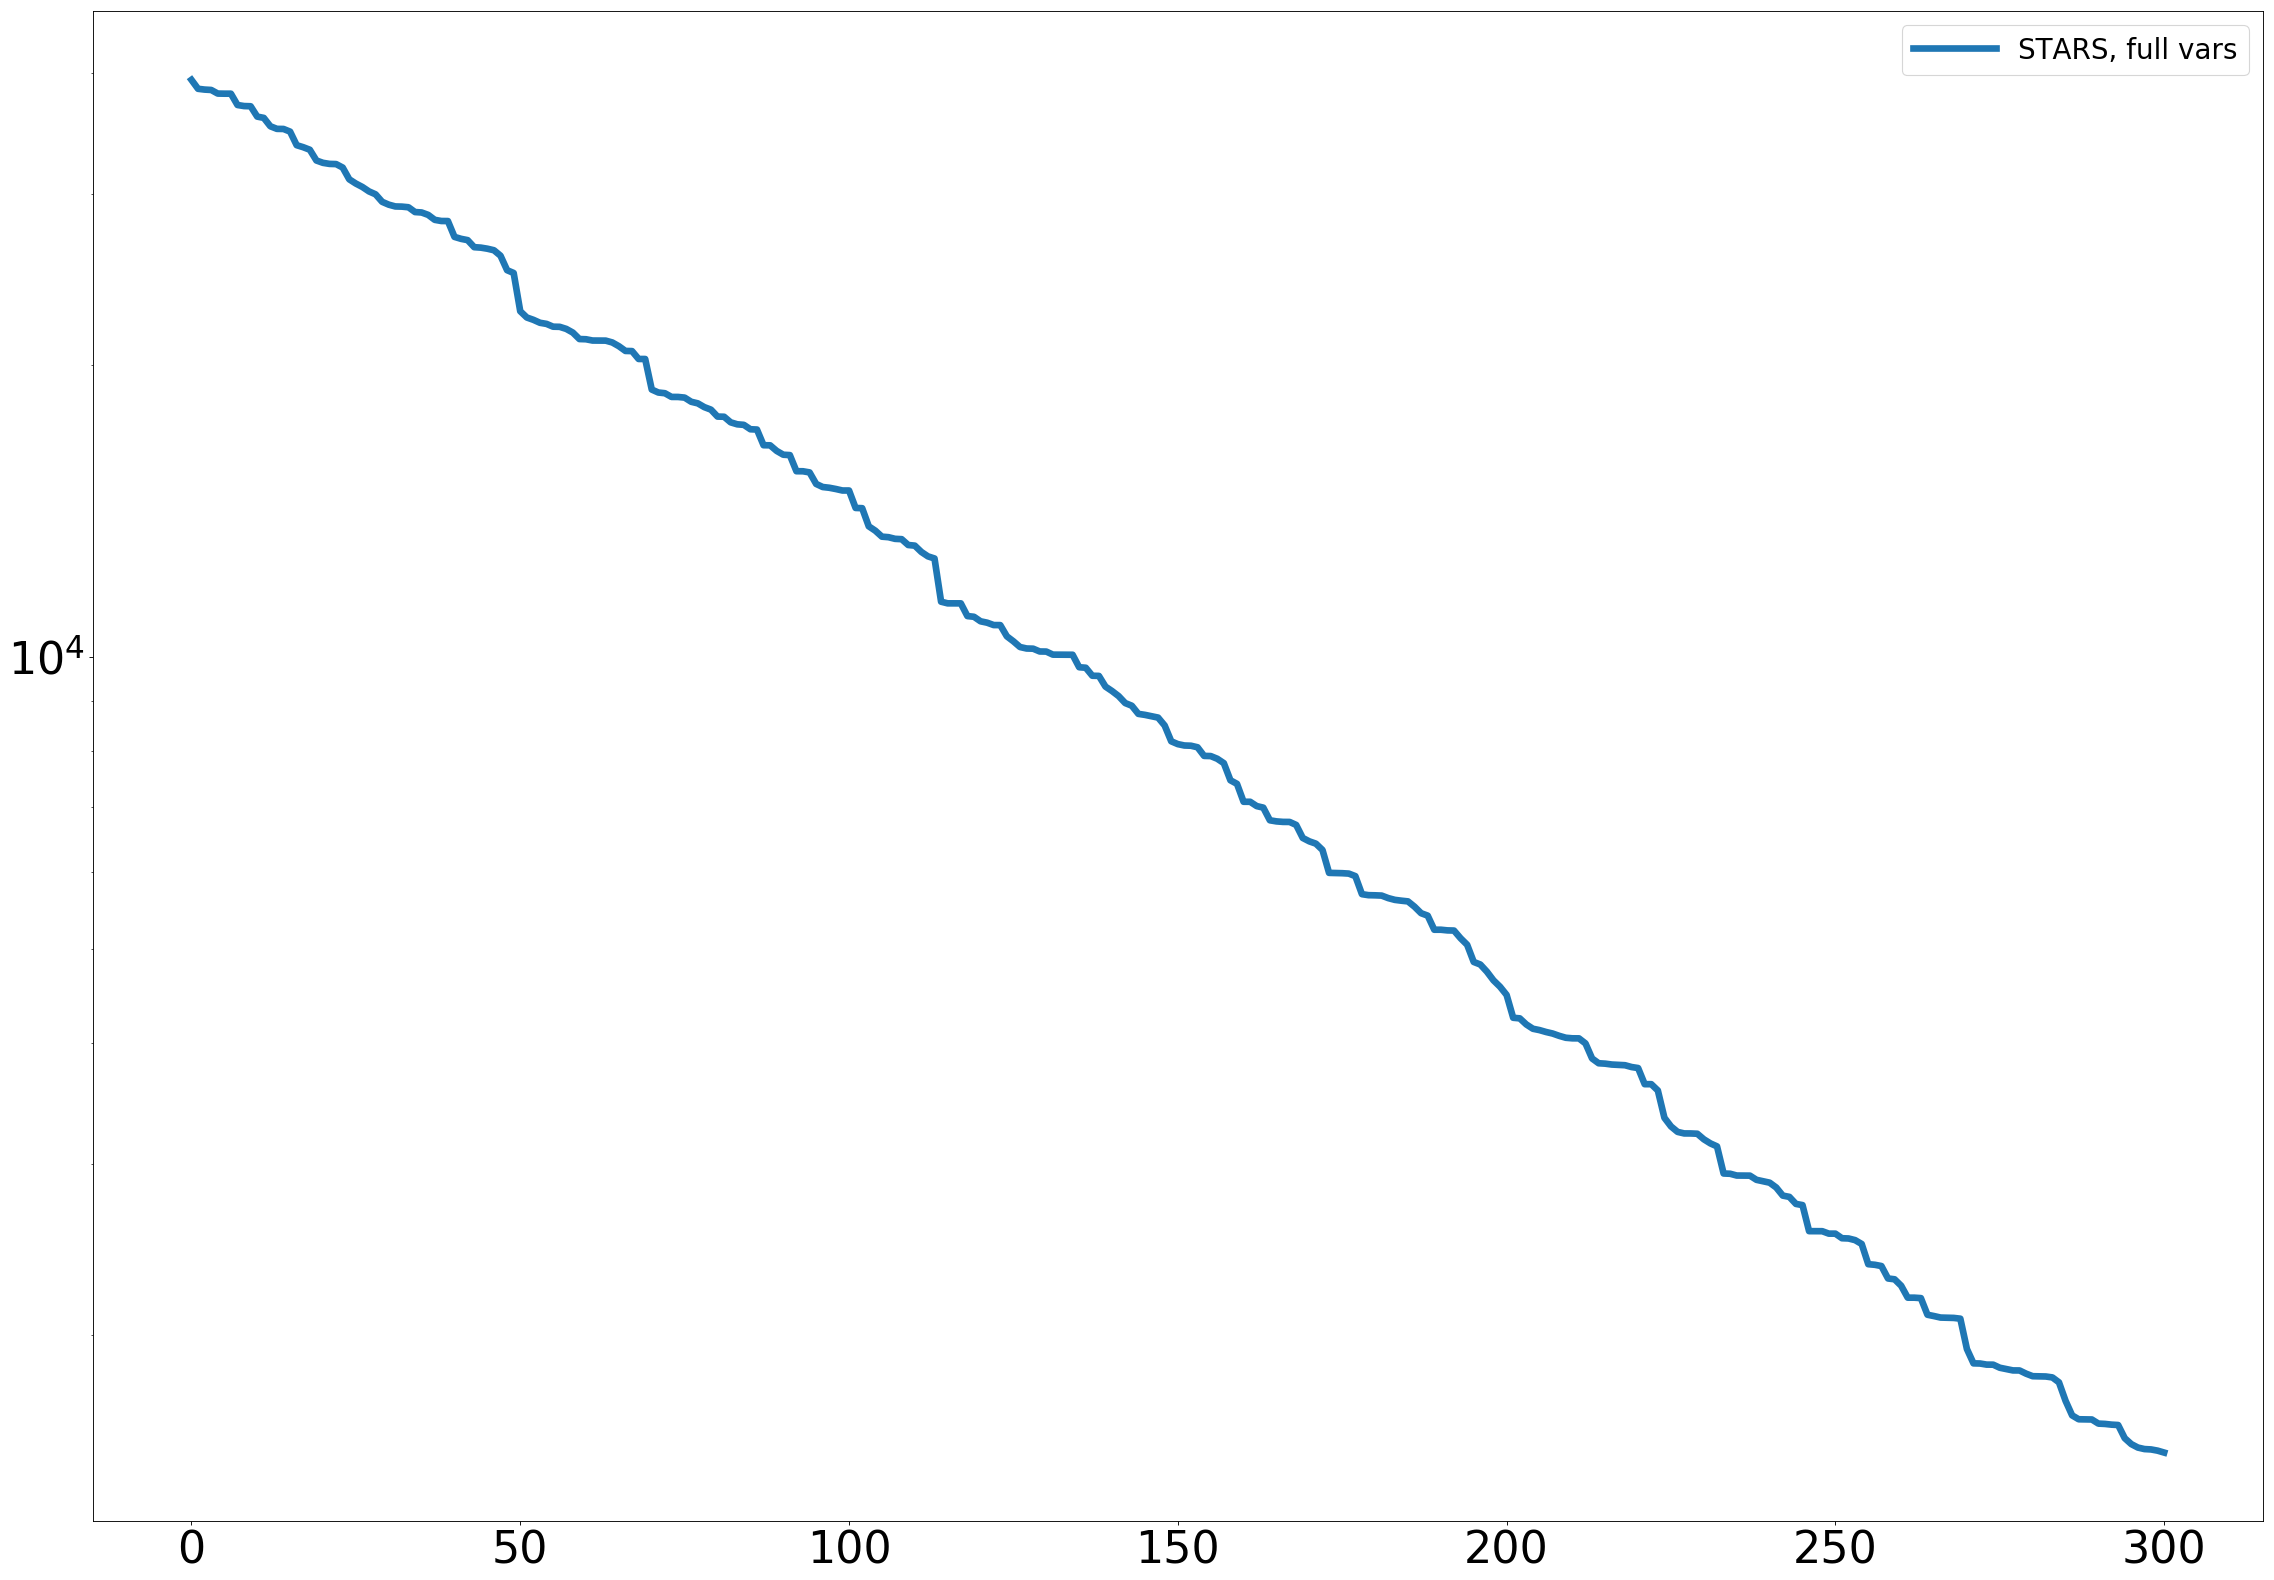

In [10]:
params = {'legend.fontsize': 25,
          'legend.handlelength': 3}
plt.rcParams["figure.figsize"] = (35,25)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 40
plt.rcParams['figure.titlesize'] = 'xx-large'
plt.rcParams.update(params)


plt.semilogy(fhist,lw=6,label='STARS, full vars')
plt.legend()
plt.show()

n should be an integer. Performing conversion.
n should be an integer. Performing conversion.
n should be an integer. Performing conversion.
n should be an integer. Performing conversion.
n should be an integer. Performing conversion.


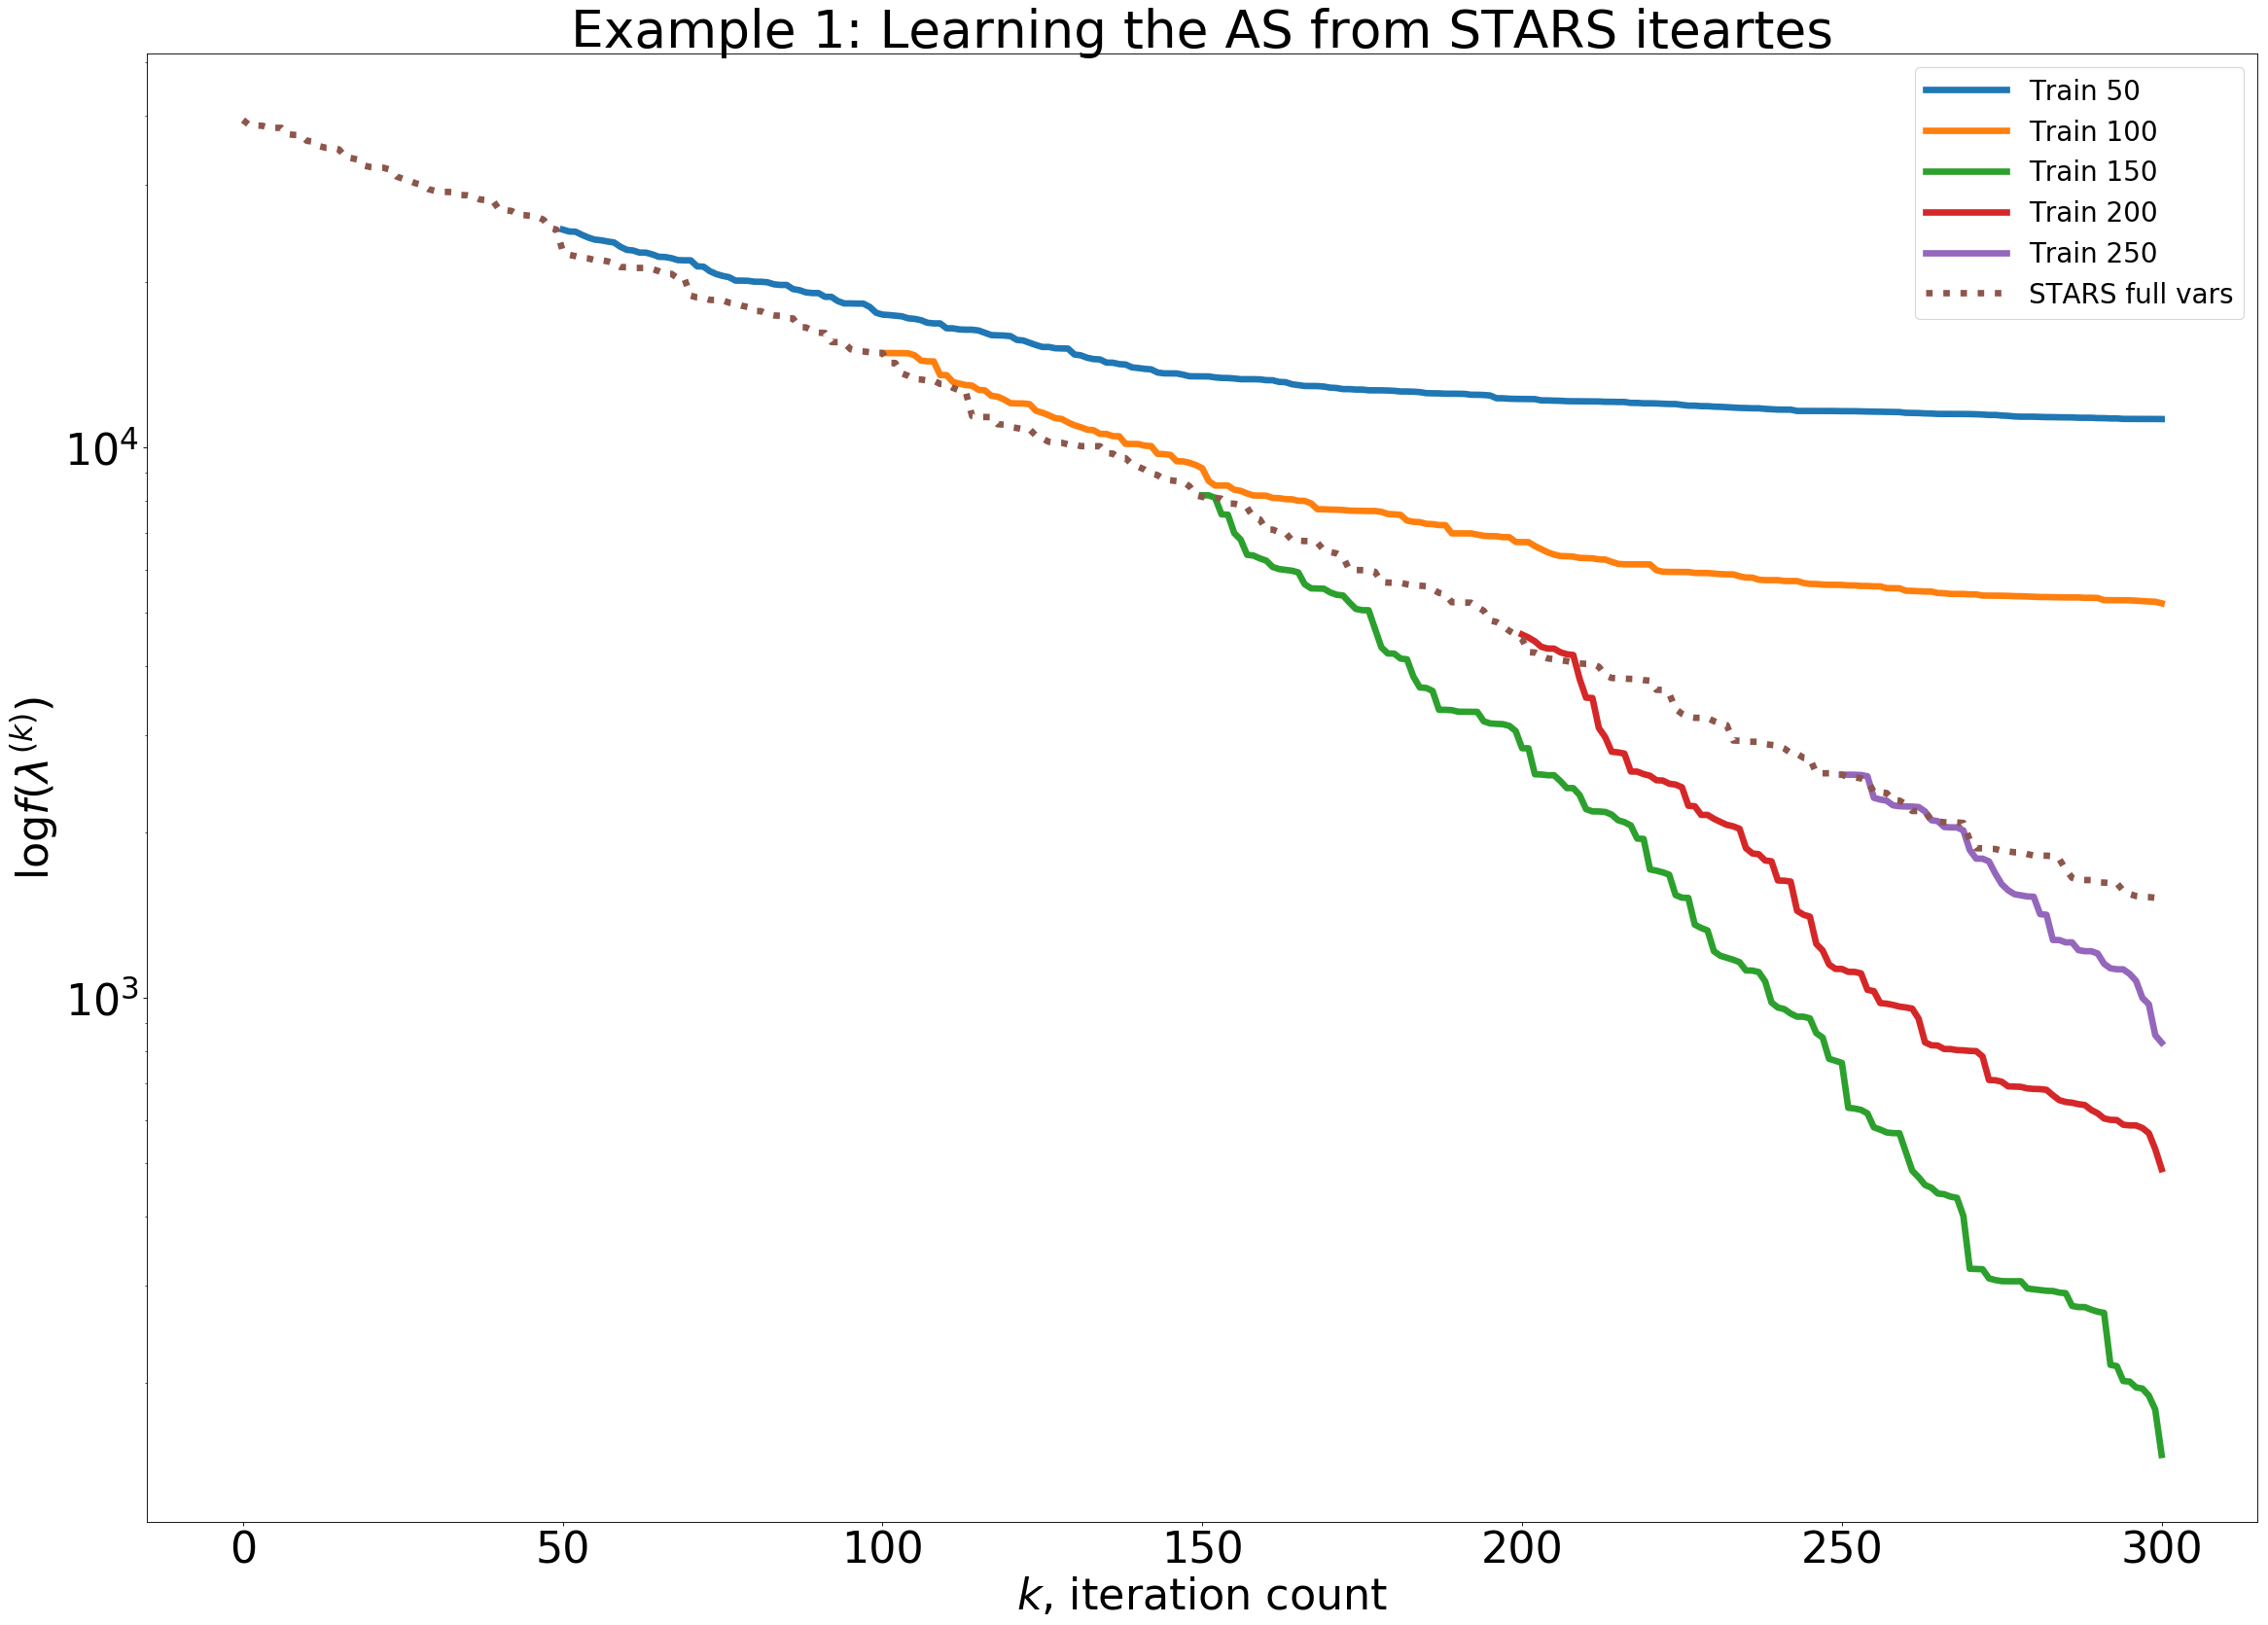

In [12]:
#plt.figure(figsize=(15,10))
ss = ac.subspaces.Subspaces()
mu_star=dfo.get_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)

for tr_stop in range(50,300,50):

    trainx=np.hstack((xhist[:,0:tr_stop],yhist[:,0:tr_stop]))
    trainf=np.vstack((fhist[0:tr_stop],ghist[0:tr_stop]))
    trainx=np.transpose(trainx)


    # Use Local Linears
    #df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    #ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    ss.compute(X=trainx, f=trainf, nboot=0, sstype='QPHD')

    sub=ss.eigenvecs[:,0:3]
    our_wts=np.sqrt(ss.eigenvals)
 
    x4=np.transpose([xhist[:,tr_stop-1]])
    xhist4=np.array(x4)
    fhist4=np.array(tfun(x4))


    for i in range(0,300-tr_stop):
        [x4,f,temp,temp2,p,q,L1B]=dfo.STARS(x4,tfun,mu_star,h,active=sub,wts=None)
        xhist4=np.hstack((xhist4,x4))
        fhist4=np.vstack((fhist4,f))
    plt.semilogy(range(tr_stop,301),fhist4,label='Train '+str(tr_stop),lw=6)


plt.semilogy(fhist, ls=':', lw=6, label='STARS full vars')

plt.xlabel('$k$, iteration count')
plt.ylabel('$\log f(\lambda^{(k)})$')
plt.title('Example 1: Learning the AS from STARS iteartes')
plt.legend()
plt.show()

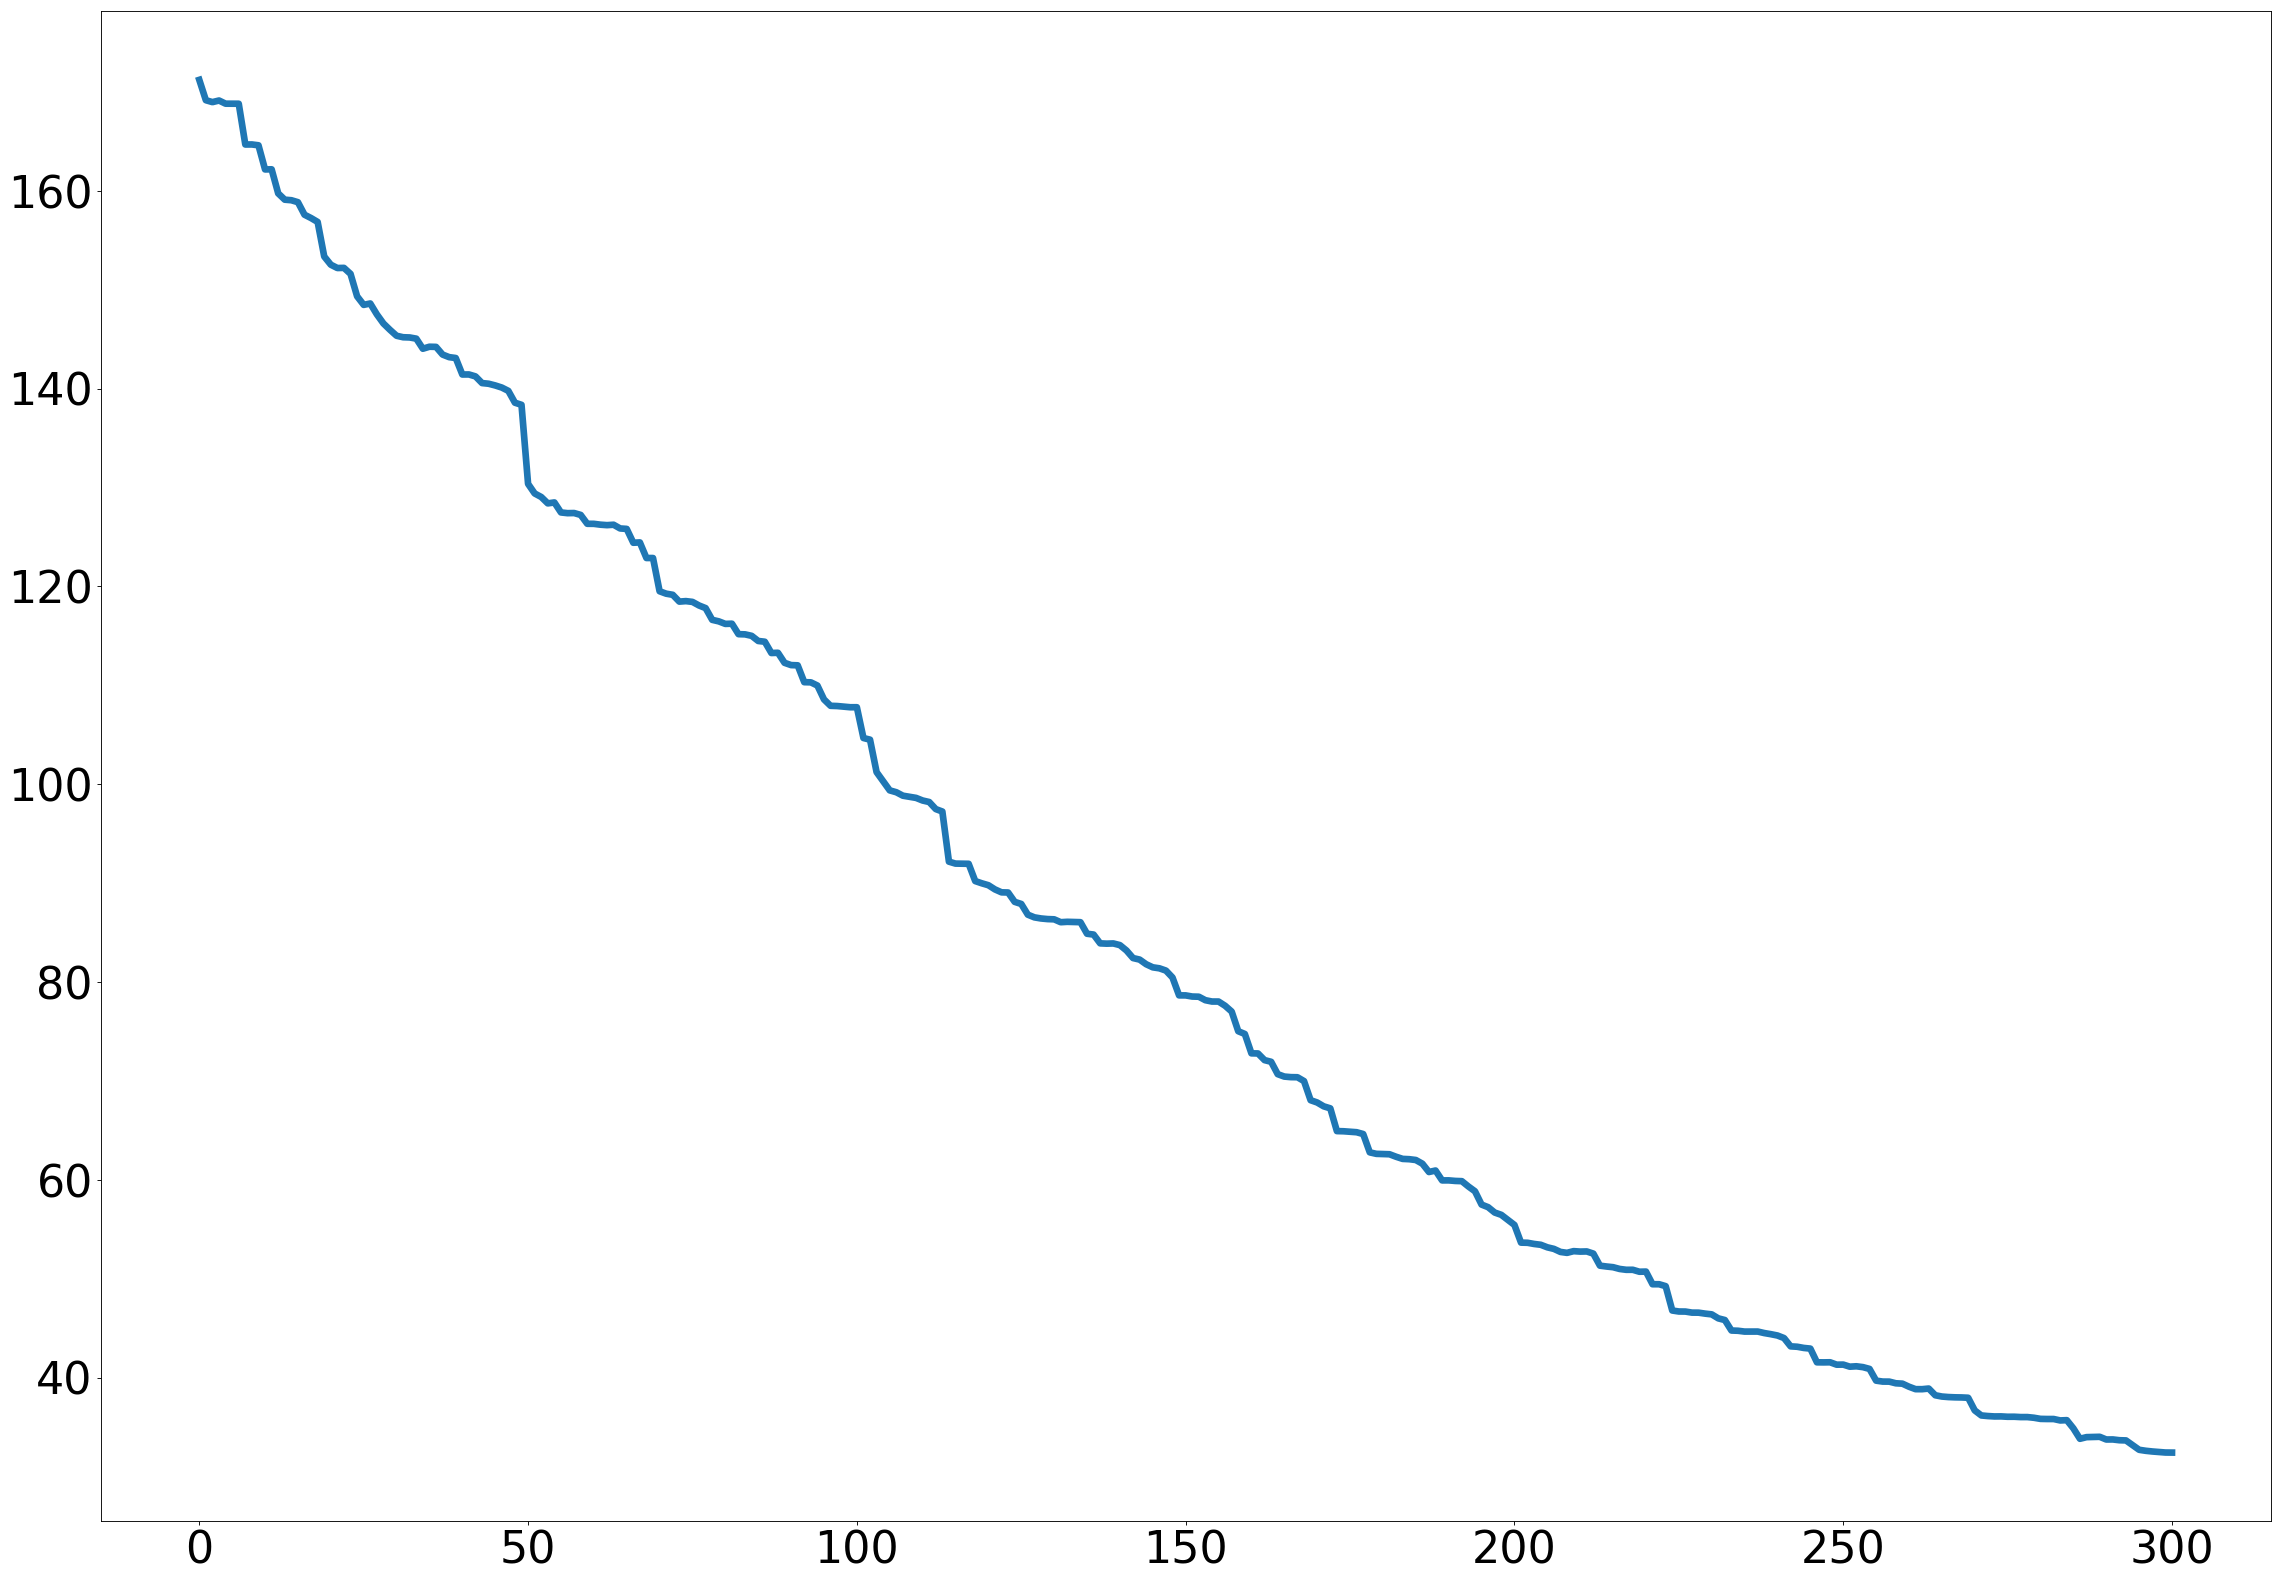

In [24]:
plt.plot(xhist[2],lw=6)

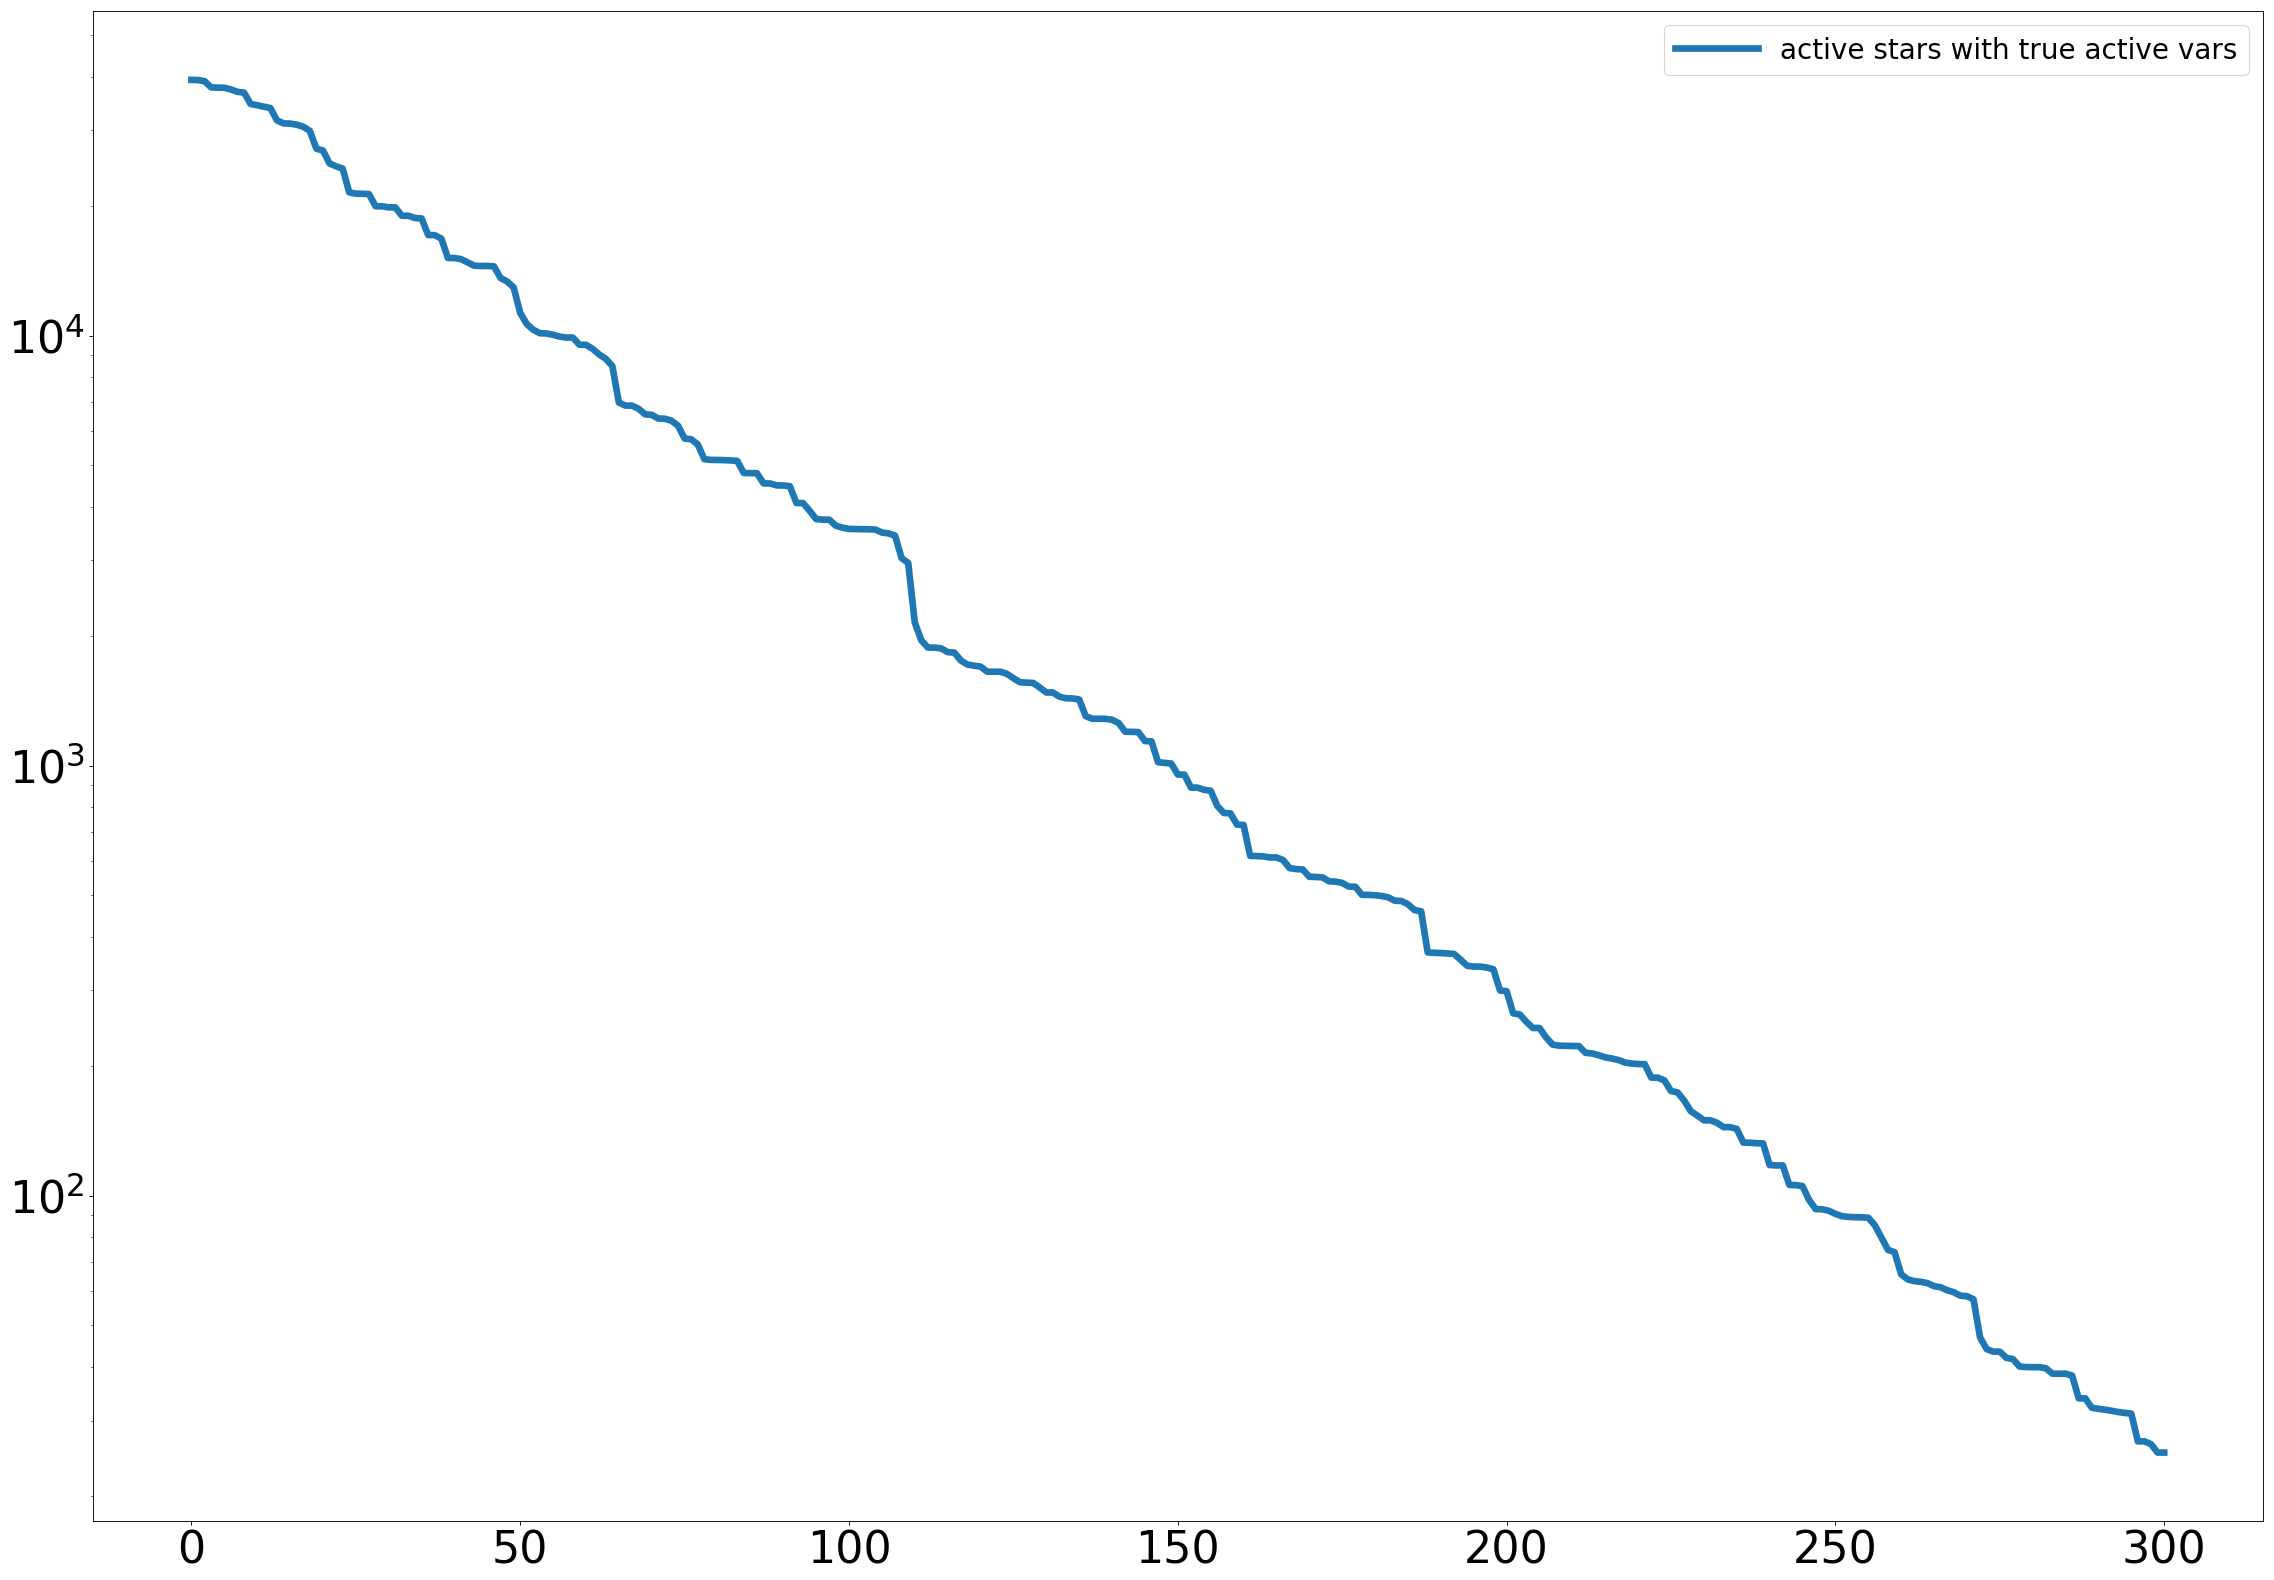

In [14]:
mu_star=dfo.get_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)


x3=np.copy(xinit)
xhist3=np.array(x3)
fhist3=np.array(tfun(x3))
active=np.eye(dim)
active=np.transpose(active[0:3,:])
eigenvals=np.zeros((dim,1))
for i in range(3):
    eigenvals[i]=1


for i in range(300):
    [x3,f,temp1,temp2, p ,q,L1B]=dfo.STARS(x3,tfun,mu_star,h,active=active,wts=None)
    xhist3=np.hstack((xhist3,x3))
    fhist3=np.vstack((fhist3,f))
    
plt.semilogy(fhist3,lw=6, label='active stars with true active vars')
plt.legend()
plt.show()

n should be an integer. Performing conversion.


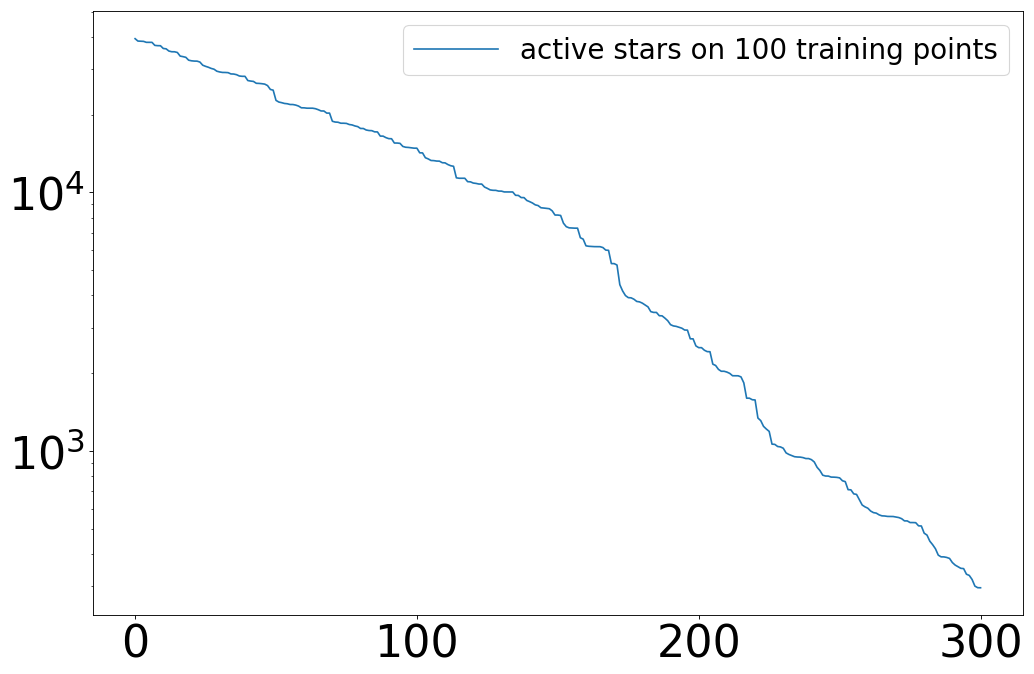

In [18]:
plt.figure(figsize=(15,10))
ss = ac.subspaces.Subspaces()
mu_star=dfo.get_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)

tr_stop=150

trainx=np.hstack((xhist[:,0:tr_stop],yhist[:,0:tr_stop]))
trainf=np.vstack((fhist[0:tr_stop],ghist[0:tr_stop]))
trainx=np.transpose(trainx)



# Use Global Quadratic
ss.compute(X=trainx, f=trainf, nboot=0, sstype='QPHD')

sub=ss.eigenvecs[:,0:3]
 
x4=np.transpose([xhist[:,tr_stop-1]])
xhist4=np.array(x4)
fhist5=np.vstack((fhist[0:tr_stop],tfun(x4)))


for i in range(0,300-tr_stop):
    [x4,f,temp,temp2,p,q,L1B]=dfo.STARS(x4,tfun,mu_star,h,active=sub,wts=None)
    xhist4=np.hstack((xhist4,x4))
    fhist5=np.vstack((fhist5,f))


plt.semilogy(fhist5, label='active stars on 100 training points')
plt.legend()
plt.show()

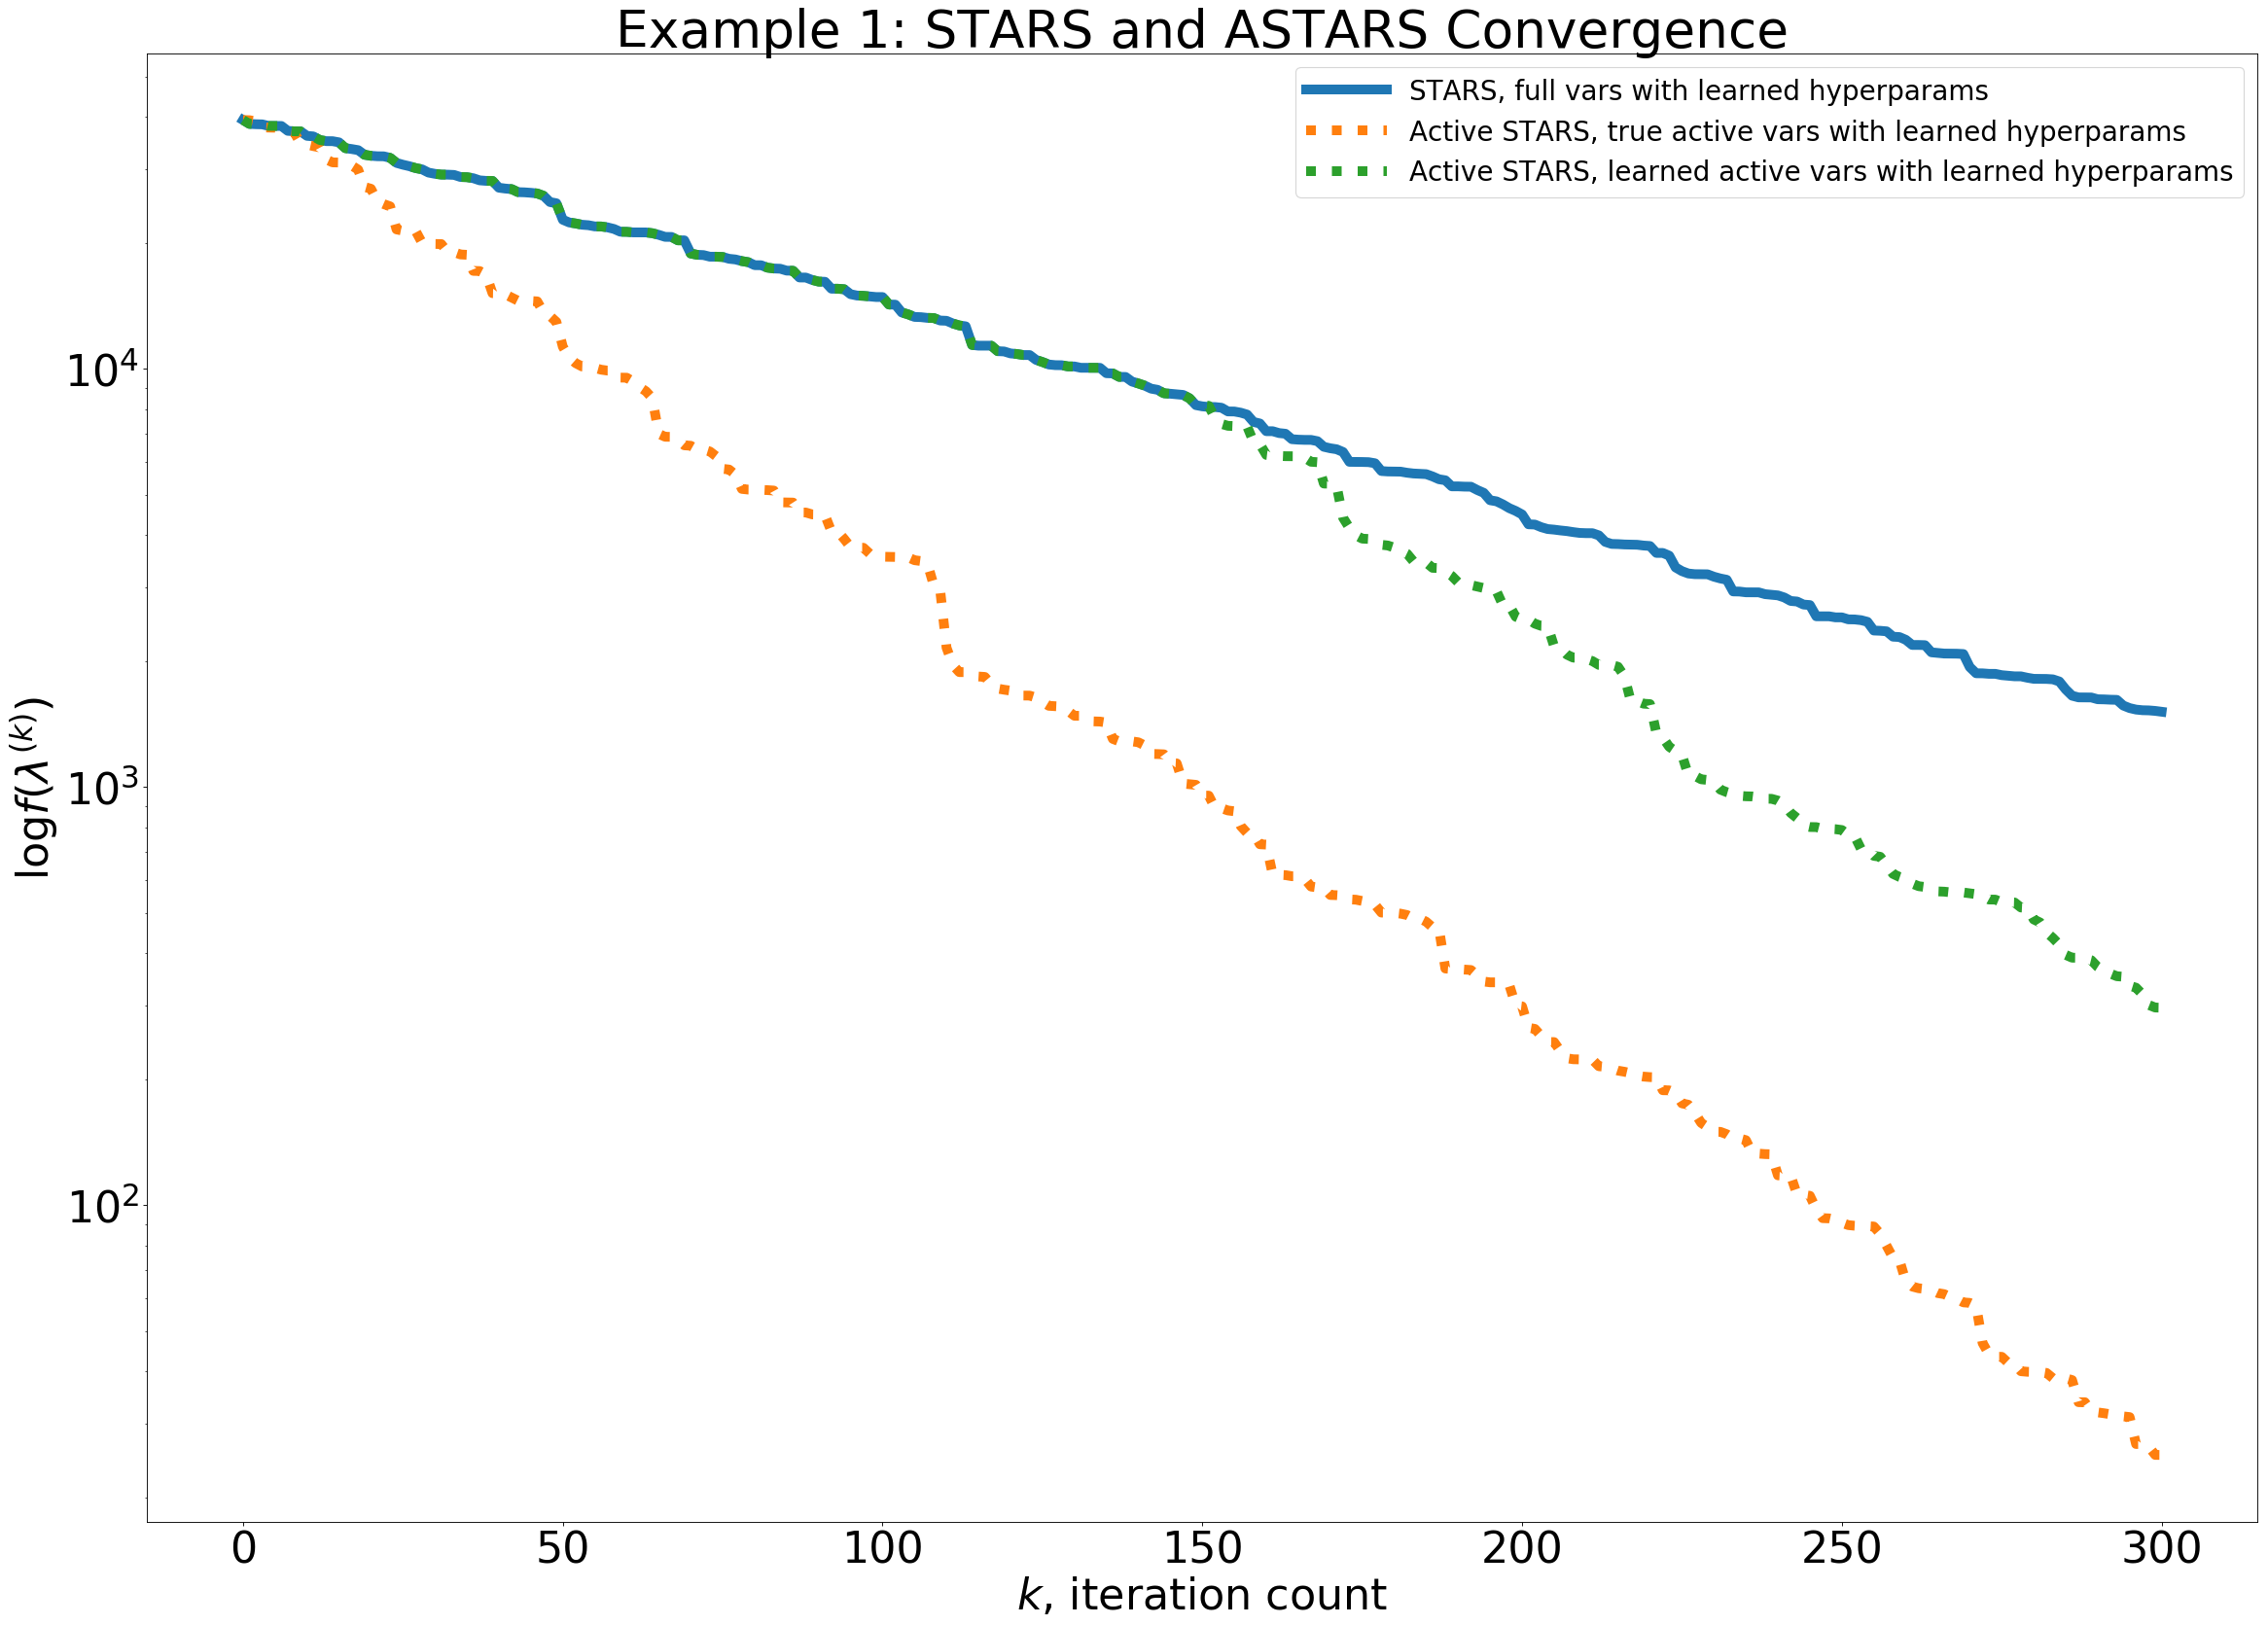

In [19]:
plt.xlabel('$k$, iteration count')
plt.ylabel('$\log f(\lambda^{(k)})$')
plt.title('Example 1: STARS and ASTARS Convergence')

plt.semilogy(fhist, lw=9, label='STARS, full vars with learned hyperparams')
plt.semilogy(fhist3, lw=9, ls=':',  label='Active STARS, true active vars with learned hyperparams')
plt.semilogy(fhist5, lw=9, ls=':',label='Active STARS, learned active vars with learned hyperparams')



plt.legend()
plt.show()